In [1]:
# %matplotlib inline

import matplotlib
matplotlib.use('pgf')
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
    "pgf.rcfonts" : False
}
matplotlib.rcParams.update(pgf_with_rc_fonts)

from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import glob
import os
import scipy.misc
import scipy.stats as st
import numpy as np
import json

from skimage.draw import line_aa

import sys
sys.path.append("/home/joshua/Documents/Uni/Year4/dissertation/catkin_ws/src/linefollow_gazebo/scripts")
# sys.path.append("/local/scratch/js2173/diss/AV-Camera-Placement/src/linefollow_gazebo/scripts/")

# import helper as helper
import CameraModel as CameraModel

plt.style.use('ggplot')
from matplotlib import rc

rc('text', usetex=True)
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['axes.edgecolor'] = '0.4'
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['grid.color'] = "0.9"

plt.tight_layout(.5)



In [2]:
def get_predicted_error_radius(camera_height,
                               ground_distance, 
                               pixel_area,
                               sigma_pos=0.03/2.0,
                               sigma_orient_deg=0.5/2,
                               alg_error=4.0, # note: changed
                               verbose=False,
                               orientation_percent=0.9,
                               pos_percent=0.9,
                               alg_percent=0.9,
                               use_err_xy=True,
                               use_err_z=True,
                               use_err_orient=True,
                               use_err_pixel=True
                              ):
    # TODO this is wrong implementation! Doesn't matter though really as long as use is consistent
    # but really it should be -1*norm.ppf((1-percent)/2.0)
    # as it is is an underestimate

    stddevs_orientation = st.norm.ppf(orientation_percent)
    stddevs_position = st.norm.ppf(pos_percent)
    stddevs_alg = st.norm.ppf(alg_percent)
    
    
    xy_error = 2 * stddevs_position * sigma_pos if use_err_xy else 0
    z_error = (ground_distance/camera_height)*stddevs_position*sigma_pos if use_err_z else 0
    
    if use_err_orient:
        t = stddevs_orientation*np.deg2rad(sigma_orient_deg)
        alpha = np.arctan2(ground_distance, camera_height)
        beta = alpha + t
        if beta > np.pi/2: # causes tan to roll over into negatives...
            orientation_error = 9999999999
        else:
            orientation_error = np.tan(beta)*camera_height - ground_distance
    else:
        orientation_error = 0
    
    pixel_error = np.sqrt(2*pixel_area) if use_err_pixel else 0
    
#     print("Z error: {0}".format(z_error))
#     print("orien error: {0}".format(orientation_error))
#     print("pixel_error: {0}".format(pixel_error))
    total = xy_error + z_error + orientation_error + (alg_error+1)/2.0 * stddevs_alg * pixel_error
    return total, xy_error, z_error, orientation_error, alg_error*pixel_error
    

In [3]:

    
   

def do_eval(real_position, 
            real_pitch_deg,
            real_yaw_deg,
            sigma_pos=0.03/2.0,
            sigma_orient_deg=0.5/2,
            alg_error=0.0,
            camera_res=(500,500),
            camera_fov=(60.0, 60.0),
            n_samples_per_camera=10,
            n_camera_instances=1,
            orientation_percent=0.90,
            pos_percent=0.9,
            alg_percent=0.9,
            use_err_xy=True,
            use_err_z=True,
            use_err_orient=True,
            use_err_pixel=True,
            verbose=False):
    
    real_camera = CameraModel.Camera(position=real_position, orientation_pitch_deg=real_pitch_deg, 
                                     orientation_yaw_deg=real_yaw_deg, verbose=False)
    real_camera.set_resolution(*camera_res)
    real_camera.set_fov(*camera_fov)

    results = {
        'true_vehicle_center':[], # placed using real_camera
        'calculated_vehicle_center':[], # project world -> biased camera -> round to pixel -> world
        'vehicle_center_prediction_error':[], # difference between above two
        'predicted_error_radius':[],
        'camera_biases':[], # enter tuples of (xyz, rp) bias
        'xy_errors': [],
        'z_errors': [],
        'orientation_errors': [],
        'pixel_alg_errors': []
    }
    for _ in range(n_camera_instances):
        offset_xyz = np.random.normal(loc=0.0, scale=sigma_pos, size=3)
        offset_rp = np.random.normal(loc=0.0, scale=sigma_orient_deg, size=2)
        biased_camera = CameraModel.Camera(position=real_position+offset_xyz, 
                                           orientation_pitch_deg=real_pitch_deg+offset_rp[0], 
                                           orientation_yaw_deg=real_yaw_deg+offset_rp[1],
                                           verbose=False
                                          )
        biased_camera.set_resolution(*camera_res)
        biased_camera.set_fov(*camera_fov)
        

        
        true_centers, calculated_centers, prediction_error, predicted_radius = [],[],[],[]
        xy_errors, z_errors, orientation_errors, pixel_alg_errors = [], [], [], []
        for i in range(n_samples_per_camera):
            
            # pick a uniformly distributed pixel to project through
            x,y = np.random.uniform(0, camera_res)
            # project through real camera to world coordinate to get something likely to be in FoV
            pt = real_camera.pixel_to_plane(x, y)
            true_centers.append(pt)
            
            # project world coordinate through biased camera
            pixel = biased_camera.world_to_pixel(*pt)
            # round to nearest pixel
            pixel = np.round(pixel)
            
            
            pixel_translation_distance = np.random.normal(loc=0.0, scale=alg_error/2.0)
            pixel_translation_direction = np.random.uniform(0.0, 2*np.pi)
            dx = pixel_translation_distance * np.cos(pixel_translation_direction)
            dy = pixel_translation_distance * np.sin(pixel_translation_direction)
            
            pixel += np.array([dx, dy])
            
            
#             print("True Pixel: ({0}, {1}), using pixel: {2}".format(x, y, pixel))
            pixel_area = real_camera.plane_area_of_pixel(*pixel) # get area in true camera (will be wrong pixel)
            # project back onto ground to get estimate as if it were the true camera
            world_estimate = real_camera.pixel_to_plane(*pixel)
            calculated_centers.append(world_estimate)
            
            if pt is None or world_estimate is None:
                continue
            # error
            error = np.linalg.norm(world_estimate - pt)
#             print("=> World plane error: \t\t{0}".format(error))
            prediction_error.append(error)
            
            # predicted error radius
            radius, xy_err, z_err, orientation_err, pixel_err  = get_predicted_error_radius(real_position[2],
                               ground_distance=np.linalg.norm(world_estimate[:2]), 
                               pixel_area=pixel_area,
                               sigma_pos=sigma_pos,
                               sigma_orient_deg=sigma_orient_deg,
                               alg_error=alg_error,
                               verbose=verbose,             
                               orientation_percent=orientation_percent,
                               pos_percent=pos_percent, 
                               use_err_xy=use_err_xy,
                               use_err_z=use_err_z,
                               use_err_orient=use_err_orient,
                               use_err_pixel=use_err_pixel
                              )
            
            predicted_radius.append(radius)
            xy_errors.append(xy_err)
            z_errors.append(z_err)
            orientation_errors.append(orientation_err)
            pixel_alg_errors.append(pixel_err)
            
#             print("=> Predicted error radius:  \t\t{0}".format(radius))
            
            
            
            if verbose and radius < error:
                print("Offset XYZ: {0}, RP: {1}".format(offset_xyz, offset_rp))
                print("True pixel & ground area: {0}, {1}".format((x,y), real_camera.plane_area_of_pixel(*np.round([x,y]))))
                print("True world pos: {0}".format(pt))
                print("Biased pixel: {0}".format(pixel))
                print("Pixel Ground area in true camera: {0}".format(pixel_area))
                print("World pos estimate: {0}".format(world_estimate))
                print("Error: {0}".format(error))
                print("Predicted Error Radius: {0}".format(radius))
                print("-----------------")
        results['true_vehicle_center'].append(np.array(true_centers))
        results['calculated_vehicle_center'].append(np.array(calculated_centers))
        results['vehicle_center_prediction_error'].append(np.array(prediction_error))
        results['predicted_error_radius'].append(np.array(predicted_radius))
        results['camera_biases'].append(np.array([offset_xyz, offset_rp]))
        results['xy_errors'].append(xy_errors)
        results['z_errors'].append(z_errors)
        results['orientation_errors'].append(orientation_errors)
        results['pixel_alg_errors'].append(pixel_alg_errors)

    results['true_vehicle_center'] = np.array(results['true_vehicle_center'])
    results['calculated_vehicle_center'] = np.array(results['calculated_vehicle_center'])
    results['vehicle_center_prediction_error'] = np.array(results['vehicle_center_prediction_error'])
    results['predicted_error_radius'] = np.array(results['predicted_error_radius'])
    results['xy_errors'] = np.array(results['xy_errors'])
    results['z_errors'] = np.array(results['z_errors']) 
    results['orientation_errors'] = np.array(results['orientation_errors'])
    results['pixel_alg_errors'] = np.array(results['pixel_alg_errors'])
    results['camera_biases'] = np.array(results['camera_biases'])

    return results




In [4]:
def evaluate_error_model(camera_height_range=(4.0, 10.0), 
                         camera_pitch_range=(32.0, 90.0), 
                         camera_pos_samples=100, 
                         camera_instances_per=50, 
                         samples_per_camera=50, 
                         sigma_pos=0.03/2, 
                         sigma_orient_deg=0.5/2, 
                         alg_error=1.0, 
                         use_err_xy=True,
                         use_err_z=True,
                         use_err_orient=True,
                         use_err_pixel=True,      
                         orientation_percent=0.9,
                         pos_percent=0.9, 
                         alg_percent=0.9,
                         camera_resolution=(500,500)
                        ):
    all_results = []
    
    for _ in range(camera_pos_samples):
        height, pitch = np.random.uniform(*np.array([camera_height_range, camera_pitch_range]).T)
        all_results.append(
            do_eval(np.array([0.0, 0.0, height]), 
                pitch,
                0.0,
                sigma_pos=sigma_pos,
                sigma_orient_deg=sigma_orient_deg,
                alg_error=alg_error,
                camera_res=camera_resolution,
                camera_fov=(60.0, 60.0),
                n_samples_per_camera=samples_per_camera,
                n_camera_instances=camera_instances_per,
                orientation_percent=orientation_percent,
                pos_percent=pos_percent, 
                alg_percent=alg_percent,
                use_err_xy=use_err_xy,
                use_err_z=use_err_z,
                use_err_orient=use_err_orient,
                use_err_pixel=use_err_pixel
            )
        )
    return all_results
    
    

In [5]:
outlier_cutoff = 3.0
save = True

### 1 show without pixel error, radii are gaussian...ish

In [5]:
no_pixel = evaluate_error_model(camera_pos_samples=100, camera_instances_per=50, samples_per_camera=25,
                                use_err_pixel=False)

NameError: global name 'np' is not defined

Number of outliers (>3.0) discarded: 690/125000 ... 0.00552
Mean: 0.171405546682, stddev: 0.226454651252


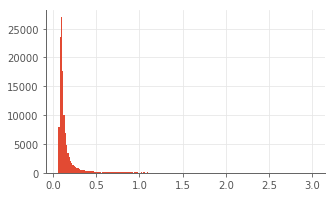

In [7]:
plt.clf()
plt.figure(figsize=(5,3))
all_radii_no_pixel = np.array([res['predicted_error_radius'] for res in no_pixel]).ravel()
outliers = all_radii_no_pixel > outlier_cutoff
num_outliers, total = np.count_nonzero(outliers), all_radii_no_pixel.shape[0]
non_outliers = all_radii_no_pixel[~outliers]
plt.hist(non_outliers, bins=200)
print("Number of outliers (>{3}) discarded: {0}/{1} ... {2}".format(num_outliers, total, num_outliers/float(total), outlier_cutoff))
print("Mean: {0}, stddev: {1}".format(np.mean(non_outliers), np.var(non_outliers)**0.5 ))
# plt.tight_layout()
if save:
    plt.savefig("figs/no-pixel-error.pdf",bbox_inches='tight')
else:
    plt.show()
plt.clf()

### 1.5 show with pixel error, radii are less gaussian (linear error as a function of ) hmmm... ignore
This is actually more gaussian...

In [8]:
with_pixel_err = evaluate_error_model(camera_pos_samples=100, camera_instances_per=50, samples_per_camera=25,
                                use_err_pixel=True)

Number of outliers (>3.0) discarded: 257/125000 ... 0.002056
Mean: 0.195528258377
stddev: 0.212233486087
Median: 0.140157614093


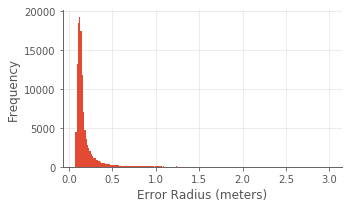

In [9]:
plt.clf()
plt.figure(figsize=(5,3))

all_radii_with_pixel = np.array([res['predicted_error_radius'] for res in with_pixel_err]).ravel()
outliers = all_radii_with_pixel > outlier_cutoff
num_outliers, total = np.count_nonzero(outliers), all_radii_with_pixel.shape[0]
non_outliers = all_radii_with_pixel[~outliers]
plt.hist(non_outliers, bins=200)
print("Number of outliers (>{3}) discarded: {0}/{1} ... {2}".format(num_outliers, total, num_outliers/float(total), outlier_cutoff))
print("Mean: {0}".format(np.mean(non_outliers)))
print("stddev: {0}".format(np.var(non_outliers)**0.5 ))
print("Median: {0}".format(np.median(non_outliers)))

plt.ylabel("Frequency")
plt.xlabel("Error Radius (meters)")
plt.tight_layout()
if save:
    plt.savefig("figs/error_radius_distribution.pdf",bbox_inches='tight')
    plt.savefig("figs/error_radius_distribution.pgf",bbox_inches='tight')
else:
    plt.show()

### 2. Show that most of the true errors are less than the predicted ones

In [47]:
sampled_results = evaluate_error_model(camera_pos_samples=50, camera_instances_per=50, samples_per_camera=50)

In [48]:
all_errors = np.array([res['vehicle_center_prediction_error'] for res in sampled_results]).ravel()
all_radii = np.array([res['predicted_error_radius'] for res in sampled_results]).ravel()
outlier_cutoff_2 = 99999
outliers = all_radii > outlier_cutoff_2 # remove all the ones with too high of a predicted error radius

# remove outliers
errors = all_errors[~outliers]
radii = all_radii[~outliers]

# count correctly within radius
errs_within_radii = errors < radii
n_within, n_total = np.count_nonzero(errs_within_radii), all_radii.shape[0]

print("Errors within predicted error radius: {0}/{1} ... {2}".format(n_within, n_total, float(n_within)/n_total))
print("Errors not within error radius: {0}/{1} ... {2}".format(n_total-n_within, n_total, float(n_total-n_within)/n_total))



Errors within predicted error radius: 123642/125000 ... 0.989136
Errors not within error radius: 1358/125000 ... 0.010864


In [49]:
print("outliers removed (>{0}): {1} ... {2}".format(outlier_cutoff, np.count_nonzero(outliers), np.count_nonzero(outliers)/float(outliers.shape[0])))

outliers removed (>4.0): 0 ... 0.0


In [56]:
plt.clf()
plt.figure(figsize=(4,3))
# examine distribution of differences
diffs = radii - errors
inside_diffs = diffs[diffs >= 0]
outside_diffs = diffs[diffs < 0]
print("Mean positive difference: {0}".format(np.mean(diffs[diffs > 0])))
_ = plt.hist(inside_diffs, bins=5000)
_ = plt.hist(outside_diffs, bins=500)
plt.xlim(-0.4, 1.0)
# plt.ylim(-1, 1000)
_ = plt.xlabel("Difference (Error Radius - True Distance)")
_ = plt.ylabel("Occurrences")

plt.tight_layout()
if save:
    plt.savefig('figs/diff_radius_true_error.pdf',bbox_inches='tight')
    plt.savefig('figs/diff_radius_true_error.pgf',bbox_inches='tight')
else:
    plt.show()

Mean positive difference: 0.185207433406


In [55]:
plt.clf()
plt.figure(figsize=(4,3))

percent_diff = (diffs / radii)
negative_percents = percent_diff[percent_diff < 0]
positive_percents = percent_diff[percent_diff >= 0]
plt.xlim(-1, 1)
_ = plt.xlabel("Predicted Error Radius - True Error as %")
_ = plt.ylabel("Occurrences")
_ = plt.hist(positive_percents, bins=50)
_ = plt.hist(negative_percents, bins=50)

plt.tight_layout()
if save:
    plt.savefig('figs/proportion_radius_true_error.pdf',bbox_inches='tight')
    plt.savefig('figs/proportion_radius_true_error.pgf',bbox_inches='tight')
else:
    plt.show()

### 3. How components of the error vary as the pitch angle changes
1. instantiate camera at official angle 90 pitch -> 40 pitch, at 20 degree increments
2. randomly sample and collect components of the error
3. Show how the components grow on average as pitch angle changes (3 side by side bars for easy visual comparison)


In [15]:
vary_pitch_results = []
for pitch in np.arange(31.0, 92.0, 10.0):
    vary_pitch_results.append(do_eval(np.array([0.0, 0.0, 6.0]), 
                      pitch,
                      0.0,              
                      sigma_pos=0.03/2.0,
                      sigma_orient_deg=0.05/2,
                      n_samples_per_camera=50,
                      n_camera_instances=50,
                      orientation_percent=0.9,
                      pos_percent=0.9,
                      alg_error=1.0,
                    )
    )
    
    # just spit out the error < radius stats
    radii = vary_pitch_results[-1]['predicted_error_radius'].ravel()
    errors = vary_pitch_results[-1]['vehicle_center_prediction_error'].ravel()
    within = errors < radii
    biases = vary_pitch_results[-1]['camera_biases']
    #print("Camera shifts and skews: {0}, {1}".format(biases[:, 0], biases[:, 1]))
    print("Proportion of errors within radius at pitch angle {0}: {1}".format(pitch, np.count_nonzero(within)/float(radii.shape[0])))
    print("Mean radius: {0}".format(np.mean(radii)))
    print("Median radius: {0}\n\n".format(np.median(radii)))
    
#     _ = plt.hist((radii-errors), bins=50)
#     plt.figure()
    

Proportion of errors within radius at pitch angle 31.0: 0.9864
Mean radius: 0.692934780008
Median radius: 0.156813689933


Proportion of errors within radius at pitch angle 41.0: 0.9996
Mean radius: 0.156235656169
Median radius: 0.119044359234


Proportion of errors within radius at pitch angle 51.0: 1.0
Mean radius: 0.109479105314
Median radius: 0.0980648201965


Proportion of errors within radius at pitch angle 61.0: 0.9992
Mean radius: 0.0916757064125
Median radius: 0.0862931735632


Proportion of errors within radius at pitch angle 71.0: 1.0
Mean radius: 0.0824272212865
Median radius: 0.0794607051201


Proportion of errors within radius at pitch angle 81.0: 1.0
Mean radius: 0.0775726939131
Median radius: 0.0764582681181


Proportion of errors within radius at pitch angle 91.0: 1.0
Mean radius: 0.076188323711
Median radius: 0.0763368905562




In [16]:
outlier_cutoff = 5.0
# outlier_cutoff = 99999999

plt.clf()

vary_pitch_stats_summary = {}
for index, result in enumerate(vary_pitch_results):
    angle = 31 + 10*index
    vary_pitch_stats_summary[angle] = {}
    
    total_error_radii = result['predicted_error_radius'].ravel()
    outliers = total_error_radii > outlier_cutoff
    total_error_radii = total_error_radii[~outliers]
    n_outliers, n_total = np.count_nonzero(outliers), total_error_radii.shape[0]
    print("Number of outliers removed (> {0}): {1}/{2} ... {3}".format(outlier_cutoff, n_outliers, n_total, n_outliers/float(n_total)))
    mean, median, stddev = np.mean(total_error_radii), np.median(total_error_radii), np.var(total_error_radii)**0.5
    vary_pitch_stats_summary[angle]['total_error'] = {
        'mean': mean,
        "media": median,
        '99th percentile': np.percentile(total_error_radii, 99.0),
        "stddev": stddev
    }
    
    xy_errs = result['xy_errors'].ravel() # constant
    xy_errs = xy_errs[~outliers]
    mean_xy, med_xy, stddev_xy = np.mean(xy_errs), np.median(xy_errs), np.var(xy_errs)**0.5
    percentile_xy = np.percentile(xy_errs, 99.0)
    vary_pitch_stats_summary[angle]['XY Error Radius'] = {
        'mean': mean_xy,
        'median': med_xy,
        '99th percentile': percentile_xy,
        'stddev': stddev_xy
    }
    
    z_errs = result['z_errors'].ravel()
    z_errs = z_errs[~outliers]
    mean_z, med_z, stddev_z = np.mean(z_errs), np.median(z_errs), np.var(z_errs)**0.5
    percentile_z = np.percentile(z_errs, 99.0)
    vary_pitch_stats_summary[angle]['Z Error Radius']= {
        'mean': mean_z,
        'median': med_z,
        '99th percentile': percentile_z,
        'stddev': stddev_z
    }

    orient_errs = result['orientation_errors'].ravel()
    orient_errs = orient_errs[~outliers]
    mean_or, med_or, stddev_or = np.mean(orient_errs), np.median(orient_errs), np.var(orient_errs)**0.5
    percentile_or = np.percentile(orient_errs, 99.0)
    vary_pitch_stats_summary[angle]['Orientation Error Radius']= {
        'mean': mean_or,
        'median': med_or,
        '99th percentile': percentile_or,
        'stddev': stddev_or
    }

    pixel_alg_errs = result['pixel_alg_errors'].ravel()
    pixel_alg_errs = pixel_alg_errs[~outliers]
    mean_p, med_p, stddev_p = np.mean(pixel_alg_errs), np.median(pixel_alg_errs), np.var(pixel_alg_errs)**0.5
    percentile_p = np.percentile(pixel_alg_errs, 99.0)
    vary_pitch_stats_summary[angle]['Pixel and Algorithmic Error Radius']= {
        'mean': mean_p,
        'median': med_p,
        '99th percentile': percentile_p,
        'stddev': stddev_p
    }
    
    mean_total = mean_xy + mean_z + mean_p + mean_or
    xy_mean_norm, z_mean_norm, or_mean_norm, p_mean_norm = mean_xy/mean_total, mean_z/mean_total, mean_or/mean_total, mean_p/mean_total
    
    med_total = med_xy + med_z + med_p + med_or
    xy_med_norm, z_med_norm, or_med_norm, p_med_norm = med_xy/med_total, med_z/med_total,med_or/med_total, med_p/med_total
    

    percentile_total = med_xy + med_z + med_p + med_or
    xy_med_norm, z_med_norm, or_med_norm, p_med_norm = med_xy/med_total, med_z/med_total,med_or/med_total, med_p/med_total
    
    percentile_total = percentile_xy + percentile_z + percentile_p + percentile_or
    xy_perc_norm, z_perc_norm, or_perc_norm, p_perc_norm = percentile_xy/percentile_total, percentile_z/percentile_total, percentile_or/percentile_total, percentile_p/percentile_total
    
    vary_pitch_stats_summary[angle]["normalized_summary"] = {
        "means": {
            "xy error" : xy_mean_norm,
            "z error": z_mean_norm,
            "orientation error": or_mean_norm,
            "pixel and algorithm error": p_mean_norm
        },
        "medians": {
            "xy error" : xy_med_norm,
            "z error": z_med_norm,
            "orientation error": or_med_norm,
            "pixel and algorithm error": p_med_norm
        },
        "99th percentile": {
            "xy error" : xy_perc_norm,
            "z error": z_perc_norm,
            "orientation error": or_perc_norm,
            "pixel and algorithm error": p_perc_norm
        }
    }
    # TODO stick these in a summary dict
    # TODO make them into a figure of relative important as a function of pitch angle as a sanity check

Number of outliers removed (> 5.0): 74/2426 ... 0.0305028854081
Number of outliers removed (> 5.0): 0/2500 ... 0.0
Number of outliers removed (> 5.0): 0/2500 ... 0.0
Number of outliers removed (> 5.0): 0/2500 ... 0.0
Number of outliers removed (> 5.0): 0/2500 ... 0.0
Number of outliers removed (> 5.0): 0/2500 ... 0.0
Number of outliers removed (> 5.0): 0/2500 ... 0.0


In [17]:
print(json.dumps(vary_pitch_stats_summary, sort_keys=True, indent=4))

{
    "31": {
        "Orientation Error Radius": {
            "99th percentile": 1.5194935271512833, 
            "mean": 0.094753303883976514, 
            "median": 0.013516806949611215, 
            "stddev": 0.2519645323943393
        }, 
        "Pixel and Algorithmic Error Radius": {
            "99th percentile": 1.5172976826906441, 
            "mean": 0.14951334166901092, 
            "median": 0.05139179050937806, 
            "stddev": 0.26708206481807417
        }, 
        "XY Error Radius": {
            "99th percentile": 0.038446546966338008, 
            "mean": 0.038446546966338008, 
            "median": 0.038446546966338008, 
            "stddev": 0.0
        }, 
        "Z Error Radius": {
            "99th percentile": 0.40621637237311392, 
            "mean": 0.063512191484876107, 
            "median": 0.033433148097501052, 
            "stddev": 0.077170754310293896
        }, 
        "normalized_summary": {
            "99th percentile": {
                "

In [18]:
def sidebyside_bar(series, xlabels, series_labels, ylabel, xlabel, error_bars=None, label_suffix="", label_multiplier=1, label_decimals=2, figsize=(8,6), width=0.27, label_height_offset_mult=1.0, legend_loc='best'):
    if error_bars is None:
        error_bars = np.zeros_like(series)
        
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    n = series.shape[1]
    ind = (np.arange(n) - 0.5) * (width/0.27)
    
    width = width * 3 / len(series_labels)
    
    rects = []
    for index, data in enumerate(series):
        yerr = error_bars[index]
        if yerr is None:
            yerr = np.zeros_like(data)
        rects.append(ax.bar(ind + width*index, data, width, yerr=yerr))
        
    ax.set_ylabel(ylabel)
    ax.set_xticks(ind + 0.5 * (len(series_labels) -1) *width)
    ax.set_xticklabels( xlabels )
    ax.legend( rects, series_labels, loc=legend_loc)
    ax.set_xlabel(xlabel)
    
    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., h+0.005*label_height_offset_mult, ('%.'+str(label_decimals)+'f')%float(h*label_multiplier) + label_suffix,
                    ha='center', va='bottom')
    
    for r in rects:
        autolabel(r)
    
    
    

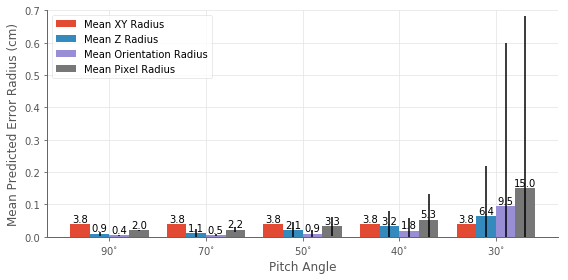

In [19]:
plt.clf()

plt.figure(figsize=(5,3))

# plot absolute errors -- this is the most informative! Using means tells the best story, but tell reader to be aware of massive skews

angles = [90, 70, 50, 40, 30]
xy = np.array([vary_pitch_stats_summary[angle + 1]["XY Error Radius"]['mean'] for angle in angles])
xy_stddev = np.array([vary_pitch_stats_summary[angle + 1]["XY Error Radius"]['stddev'] for angle in angles])

z =  np.array([vary_pitch_stats_summary[angle + 1]["Z Error Radius"]["mean"] for angle in angles])
z_stddev =  np.array([vary_pitch_stats_summary[angle + 1]["Z Error Radius"]["stddev"] for angle in angles])

orientation = np.array([vary_pitch_stats_summary[angle + 1]["Orientation Error Radius"]["mean"] for angle in angles])
orientation_stddev = np.array([vary_pitch_stats_summary[angle + 1]["Orientation Error Radius"]["stddev"] for angle in angles])

pixel = np.array([vary_pitch_stats_summary[angle + 1]["Pixel and Algorithmic Error Radius"]["mean"] for angle in angles])
pixel_stddev = np.array([vary_pitch_stats_summary[angle + 1]["Pixel and Algorithmic Error Radius"]["stddev"] for angle in angles])
legend = ["Mean XY Radius", "Mean Z Radius", "Mean Orientation Radius", "Mean Pixel Radius"]

xticks = [u"${}^{{\circ}}$".format(angle) for angle in angles]
# width = 0.4
# ind = np.arange(0, len(angles))
# bars = []
# bars.append(plt.bar(ind, xy, width, yerr=xy_stddev))
# bars.append(plt.bar(ind, z, width, bottom=xy, yerr=z_stddev))
# bars.append(plt.bar(ind, orientation, width, bottom=xy+z, yerr=orientation_stddev,ecolor='purple'))
# bars.append(plt.bar(ind, pixel, width, bottom=xy+z+orientation, yerr=pixel_stddev,ecolor='gray'))

# plt.ylabel("Mean Predicted Error Radius (meters)")
# plt.xlabel("Pitch Angle")
# plt.xticks(ind, xticks)
# plt.legend(bars, legend)

sidebyside_bar(np.array([xy, z, orientation, pixel]), xticks, legend, "Mean Predicted Error Radius (cm)", "Pitch Angle", error_bars=2*np.array([xy_stddev, z_stddev, orientation_stddev, pixel_stddev]), label_decimals=1, label_multiplier=100, figsize=(8,4), label_height_offset_mult=0.25, legend_loc='upper left')
plt.ylim(0, 0.7)
plt.tight_layout()

if save:
    plt.savefig('figs/mean_error_pitch_variation_with_stddevs.pdf',bbox_inches='tight')
    plt.savefig('figs/mean_error_pitch_variation_with_stddevs.pgf',bbox_inches='tight')
else:
    plt.show()

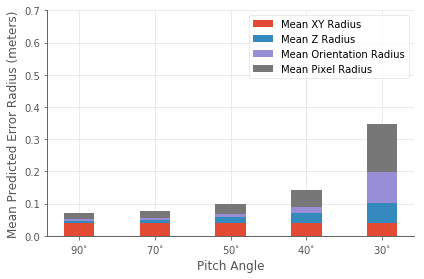

In [20]:
width = 0.4
ind = np.arange(0, len(angles))
bars = []
bars.append(plt.bar(ind, xy, width))
bars.append(plt.bar(ind, z, width, bottom=xy))
bars.append(plt.bar(ind, orientation, width, bottom=xy+z))
bars.append(plt.bar(ind, pixel, width, bottom=xy+z+orientation))

plt.ylabel("Mean Predicted Error Radius (meters)")
plt.xlabel("Pitch Angle")
plt.xticks(ind, xticks)
plt.legend(bars, legend)
plt.ylim(0, 0.7)

# sidebyside_bar(np.array([xy, z, orientation, pixel]), xticks, legend, "Mean Predicted Error Radius (cm)", "Pitch Angle", error_bars=2*np.array([xy_stddev, z_stddev, orientation_stddev, pixel_stddev]), label_decimals=1, label_multiplier=100, figsize=(8,4), label_height_offset_mult=0.25, legend_loc='upper left')
# plt.ylim(0, 0.7)
plt.tight_layout()

if save:
    plt.savefig('figs/mean_error_pitch_variation_stacked.pdf',bbox_inches='tight')
    plt.savefig('figs/mean_error_pitch_variation_stacked.pgf',bbox_inches='tight')
else:
    plt.show()

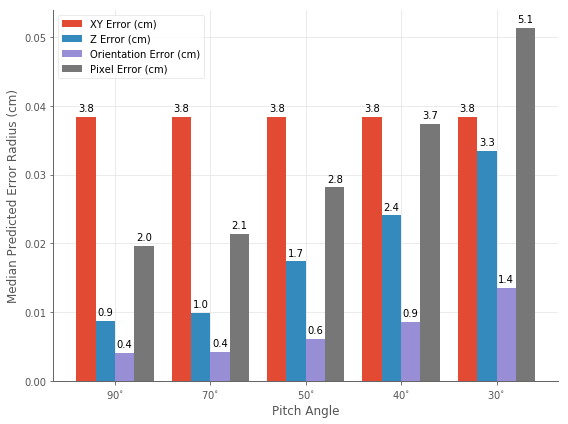

In [21]:
# plot absolute errors -- this is the quite informative!
angles = [90, 70, 50, 40, 30]
xy = np.array([vary_pitch_stats_summary[angle + 1]["XY Error Radius"]['median'] for angle in angles])
z =  np.array([vary_pitch_stats_summary[angle + 1]["Z Error Radius"]["median"] for angle in angles])
orientation = np.array([vary_pitch_stats_summary[angle + 1]["Orientation Error Radius"]["median"] for angle in angles])
pixel = np.array([vary_pitch_stats_summary[angle + 1]["Pixel and Algorithmic Error Radius"]["median"] for angle in angles])
legend = ["XY Error (cm)", "Z Error (cm)", "Orientation Error (cm)", "Pixel Error (cm)"]

xticks = [u"${}^{{\circ}}$".format(angle) for angle in angles]
sidebyside_bar(np.array([xy, z, orientation, pixel]), xticks, legend, "Median Predicted Error Radius (cm)", "Pitch Angle", label_decimals=1, label_multiplier=100, label_height_offset_mult=0.1)

plt.tight_layout()

if save:
    plt.savefig('figs/median_error_pitch_variation.pdf',bbox_inches='tight')
    plt.savefig('figs/median_error_pitch_variation.pgf',bbox_inches='tight')
else:
    plt.show()

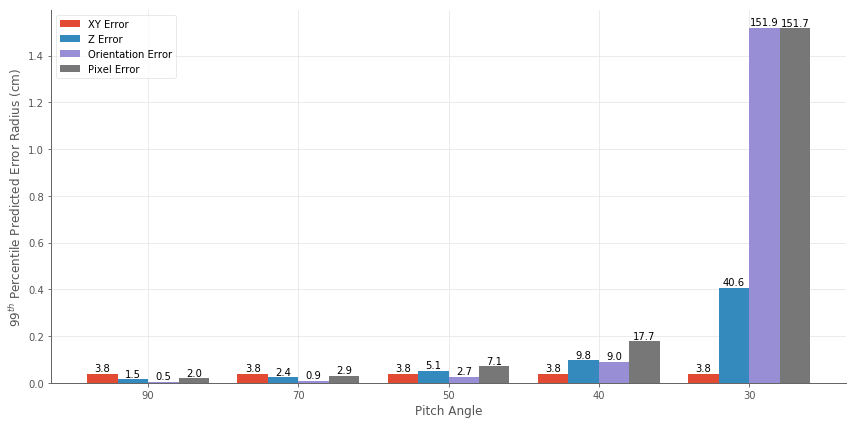

In [22]:
# plot absolute errors -- this is the most informative!
angles = [90, 70, 50, 40, 30]
xy = np.array([vary_pitch_stats_summary[angle + 1]["XY Error Radius"]['99th percentile'] for angle in angles])
z =  np.array([vary_pitch_stats_summary[angle + 1]["Z Error Radius"]["99th percentile"] for angle in angles])
orientation = np.array([vary_pitch_stats_summary[angle + 1]["Orientation Error Radius"]["99th percentile"] for angle in angles])
pixel = np.array([vary_pitch_stats_summary[angle + 1]["Pixel and Algorithmic Error Radius"]["99th percentile"] for angle in angles])
legend = ["XY Error", "Z Error", "Orientation Error", "Pixel Error"]

xticks = [u"${}^{{\circ}}$".format(angle) for angle in angles]
sidebyside_bar(np.array([xy, z, orientation, pixel]), angles, legend, u"99$^{{th}}$ Percentile Predicted Error Radius (cm)", "Pitch Angle", label_decimals=1, label_multiplier=100, figsize=(12,6), label_height_offset_mult=0.25)

plt.tight_layout()

if save:
    plt.savefig('figs/99th_percentile_error_pitch_variation.pdf',bbox_inches='tight')
    plt.savefig('figs/99th_percentile_error_pitch_variation.pgf',bbox_inches='tight')
else:
    plt.show()

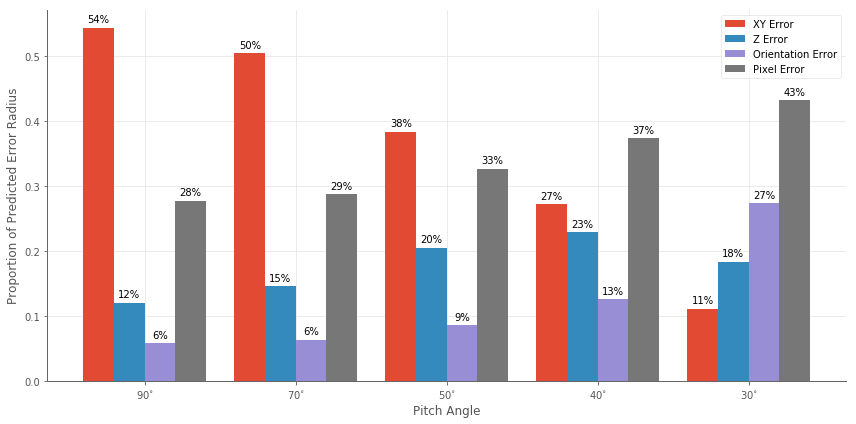

In [23]:
# collect normalized summaries
# means first

angles = [90, 70, 50, 40, 30]
xy_means = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["means"]["xy error"] for angle in angles])
z_means = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["means"]["z error"] for angle in angles])
orientation_means =  np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["means"]["orientation error"] for angle in angles])
pixel_means = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["means"]["pixel and algorithm error"] for angle in angles])
legend = ["XY Error", "Z Error", "Orientation Error", "Pixel Error"]

xticks = [u"${}^{{\circ}}$".format(angle) for angle in angles]
sidebyside_bar(np.array([xy_means, z_means, orientation_means, pixel_means]), xticks, legend, "Proportion of Predicted Error Radius", "Pitch Angle", label_suffix="%", label_decimals=0, label_multiplier=100, figsize=(12,6))

plt.tight_layout()
if save:
    plt.savefig('figs/normalized_mean_error_pitch_variation.pdf',bbox_inches='tight')
    plt.savefig('figs/normalized_mean_error_pitch_variation.pgf',bbox_inches='tight')
else:
    plt.show()

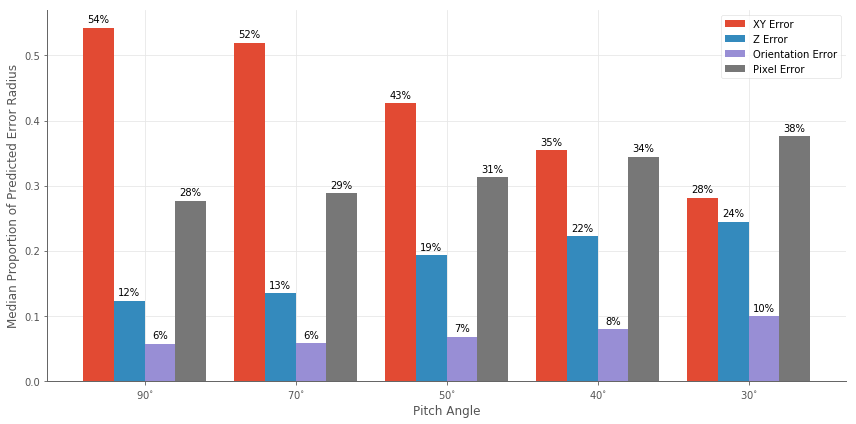

In [24]:
# less useful!
# angles = [90, 80, 70, 60, 50, 40, 30]
xy_medians = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["medians"]["xy error"] for angle in angles])
z_medians = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["medians"]["z error"] for angle in angles])
orientation_medians =  np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["medians"]["orientation error"] for angle in angles])
pixel_medians = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["medians"]["pixel and algorithm error"] for angle in angles])
legend = ["XY Error", "Z Error", "Orientation Error", "Pixel Error"]

sidebyside_bar(np.array([xy_medians, z_medians, orientation_medians, pixel_medians]), xticks, legend, "Median Proportion of Predicted Error Radius", "Pitch Angle", label_suffix="%", label_multiplier=100, label_decimals=0, figsize=(12,6))

plt.tight_layout()
if save:
    plt.savefig('figs/normalized_median_error_pitch_variation.pdf',bbox_inches='tight')
    plt.savefig('figs/normalized_median_error_pitch_variation.pgf',bbox_inches='tight')
else:
    plt.show()

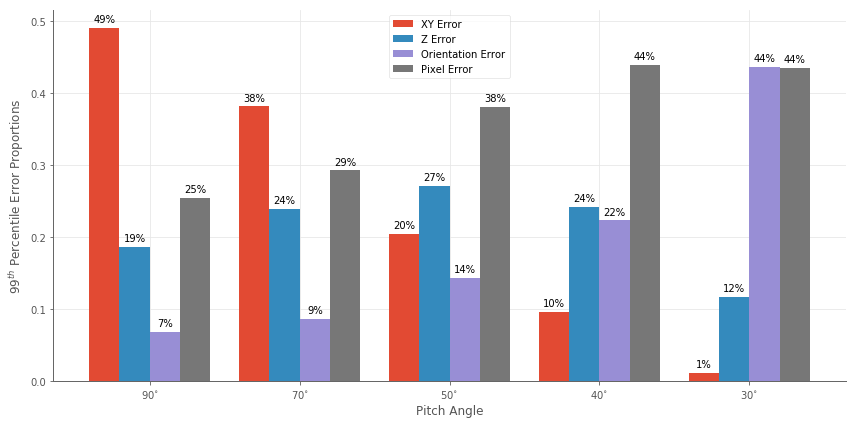

In [25]:
# normalized 99th percentile important
xy_99 = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["99th percentile"]["xy error"] for angle in angles])
z_99 = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["99th percentile"]["z error"] for angle in angles])
orientation_99 =  np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["99th percentile"]["orientation error"] for angle in angles])
pixel_99 = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["99th percentile"]["pixel and algorithm error"] for angle in angles])
legend = ["XY Error", "Z Error", "Orientation Error", "Pixel Error"]

sidebyside_bar(np.array([xy_99, z_99, orientation_99, pixel_99]), xticks, legend, u"99$^{{th}}$ Percentile Error Proportions", "Pitch Angle", label_suffix="%", label_multiplier=100, label_decimals=0, figsize=(12,6))

plt.tight_layout()
if save:
    plt.savefig('figs/normalized_99th_error_pitch_variation.pdf',bbox_inches='tight')
    plt.savefig('figs/normalized_99th_error_pitch_variation.pgf',bbox_inches='tight')
else:
    plt.show()

In [26]:
# show absolute errors a totals... also less useful
# angles = [90, 80, 70, 60, 50, 40, 30]


mean_error = np.array([vary_pitch_stats_summary[angle + 1]["total_error"]["mean"] for angle in angles])
median_error = np.array([vary_pitch_stats_summary[angle + 1]["total_error"]["media"] for angle in angles])
stddev_error = np.array([vary_pitch_stats_summary[angle + 1]["total_error"]["stddev"] for angle in angles])
percentile_99 = np.array([vary_pitch_stats_summary[angle + 1]["total_error"]['99th percentile'] for angle in angles])
three_stddev = mean_error + 3*stddev_error
legend=["Mean Error Radius (cm)", "Median Error Radius (cm)", "99th Percentile", "Mean + 3 stddev"]
print(stddev_error)
"""

sidebyside_bar(np.array([mean_error, median_error, percentile_99, three_stddev]), angles, legend, "Total Radius", "Pitch Angle", label_decimals=1, width=0.4, label_multiplier=100)
# error bars are nothing to write home about except that divergence at the top end - discuss in TABLE

"""

[ 0.00366254  0.01216779  0.03685334  0.09343279  0.6667549 ]


'\n\nsidebyside_bar(np.array([mean_error, median_error, percentile_99, three_stddev]), angles, legend, "Total Radius", "Pitch Angle", label_decimals=1, width=0.4, label_multiplier=100)\n# error bars are nothing to write home about except that divergence at the top end - discuss in TABLE\n\n'

### 4. Show impact of algorithmic error

In [34]:
outlier_cutoff = 4.0
# want to see how mean/median radius changes, as well as bound accuracy
# as algorithmic error increases
alg_means = []
alg_medians = []
alg_99th = []
alg_outliers = []
alg_within_radius = []
alg_total = []
alg_stddevs = []
for alg_error in np.arange(0.0, 25.0, 2.5):
    with_alg = evaluate_error_model(camera_pos_samples=30, camera_instances_per=30, samples_per_camera=50, alg_error=alg_error, camera_resolution=(1000,1000))
    with_alg_errors = np.array([res['vehicle_center_prediction_error'] for res in with_alg]).ravel()
    with_alg_radii = np.array([res['predicted_error_radius'] for res in with_alg]).ravel()
    outliers = with_alg_radii > outlier_cutoff # remove all the ones with too high of a predicted error radius
    n_outliers = np.count_nonzero(outliers)
    alg_outliers.append(n_outliers)
    print("Number of outliers removed: {0}/{1}".format(n_outliers, outliers.shape[0]))
    
    # remove outliers
    errors = with_alg_errors[~outliers]
    radii = with_alg_radii[~outliers]
    
    # count correctly within radius
    errs_within_radii = errors < radii
    n_within, n_total = np.count_nonzero(errs_within_radii), errors.shape[0]
    alg_within_radius.append(n_within)
    alg_total.append(n_total)
    print("Errors within predicted error radius: {0}/{1} ... {2}".format(n_within, n_total, float(n_within)/n_total))
    print("Errors not within error radius: {0}/{1} ... {2}".format(n_total-n_within, n_total, float(n_total-n_within)/n_total))
    
    mean, median, percentile, stddev = np.mean(radii), np.median(radii), np.percentile(radii, 99.0), np.var(radii)**0.5
    print("Mean radius: {0}".format(mean))
    print("Median radius: {0}".format(median))
    print("99th Percentile: {0}".format(percentile))
    print("Stddev: {0}".format(stddev))
    alg_means.append(mean)
    alg_medians.append(median)
    alg_99th.append(percentile)
    alg_stddevs.append(stddev)

Number of outliers removed: 96/45000
Errors within predicted error radius: 43931/44904 ... 0.978331551755
Errors not within error radius: 973/44904 ... 0.0216684482451
Mean radius: 0.196557376357
Median radius: 0.12486876875
99th Percentile: 1.65914807337
Stddev: 0.287995189942
Number of outliers removed: 206/45000
Errors within predicted error radius: 44459/44794 ... 0.99252131982
Errors not within error radius: 335/44794 ... 0.00747868018038
Mean radius: 0.220257612689
Median radius: 0.140361400267
99th Percentile: 1.84200815969
Stddev: 0.313406732918
Number of outliers removed: 286/45000
Errors within predicted error radius: 44407/44714 ... 0.993134141432
Errors not within error radius: 307/44714 ... 0.00686585856779
Mean radius: 0.281879809243
Median radius: 0.174027984255
99th Percentile: 2.07888299958
Stddev: 0.355444786444
Number of outliers removed: 1/45000
Errors within predicted error radius: 44850/44999 ... 0.996688815307
Errors not within error radius: 149/44999 ... 0.00331

In [35]:

# Here, plot mean radius versus algo error
# as well as bound accuracy versus algorithm error 
# plot lines on the same plot

plt.clf()
plt.figure(figsize=(5,3))
xaxis = np.arange(0.0, 25.0, 2.5)
xticks = ["{0:.2f}".format(p) for p in np.arange(0.0, 25.0, 2.5)]
# plot lines and errors for mean
plt.errorbar(xaxis, alg_means, yerr=np.array(alg_stddevs), fmt='-o')

# calculate fraction within error bound
within = np.array(alg_within_radius)
total = np.array(alg_total)
frac = within/total.astype(np.float64)
plt.plot(xaxis, frac, '-x')
    
leg = plt.legend(["Error Radius Accuracy (\%)","Mean Sampled Error Radius (meters)"])
plt.xlabel("Algorithmic Error (within two standard deviations)")
plt.xticks(xaxis)

plt.tight_layout()

if save:
    plt.savefig('figs/algorithm_influence.pdf',bbox_inches='tight')
    plt.savefig('figs/algorithm_influence.pgf',bbox_inches='tight')
else:
    plt.show()


### 5. Examine How ground area ie. fov/resolution affects accuracy

In [6]:
# want to see how mean/median radius changes, as resolution increases

resolutions = np.array([100, 300, 500, 1000, 2000, 5000, 10000])
angles = np.array([90, 70, 50, 40, 32])
data = []

for angle in angles:
    data.append([])
    for res in resolutions:
        data[-1].append(do_eval(np.array([0.0, 0.0, 6.0]), 
            float(angle),
            0.0,
            alg_error=4.0,
            camera_res=(res,res),
            n_samples_per_camera=20,
            n_camera_instances=20,
            orientation_percent=0.90,
            pos_percent=0.9,
            alg_percent=0.9)['predicted_error_radius']
        )

MemoryError: 

In [ ]:
plt.clf()
plt.figure(figsize=(5,3))
for j, angle in enumerate(angles[:-1]):
    angle_data = data[j]
    means, medians, stddevs, percentiles = [], [], [], []
    for i in range(len(resolutions)):
        res_data = angle_data[i]
        radii = res_data.ravel() 
        mean, median, stddev, percentile = np.mean(radii), np.median(radii), np.var(radii)**0.5, np.percentile(radii, 99.0)
        means.append(mean)
        stddevs.append(stddev)
    
    # plot this curve
    plt.errorbar(resolutions, means, yerr=stddev)
    print("Angle: {0}, Mean radius across resolutions: {1}".format(angle, means))
    
leg = plt.legend([u"{}$^{{\circ}}$ pitch".format(a) for a in angles])
plt.xlabel("Horizontal and Vertical Resolution")
plt.ylabel("Mean Sampled Error Radius (meters)")
# plt.show()
plt.tight_layout()

if save:
    plt.savefig('figs/resolution_angle_effects_mean.pdf',bbox_inches='tight')
    plt.savefig('figs/resolution_angle_effects_mean.pgf',bbox_inches='tight')
else:
    plt.show()
plt.clf()

plt.figure(figsize=(5,3))
for j, angle in enumerate(angles[:-1]):
    angle_data = data[j]
    means, medians, stddevs, percentiles = [], [], [], []
    for i in range(len(resolutions)):
        res_data = angle_data[i]
        radii = res_data.ravel() 
        mean, median, stddev, percentile = np.mean(radii), np.median(radii), np.var(radii)**0.5, np.percentile(radii, 99.0)
        medians.append(median)
        percentiles.append(percentile)
    
    # plot this curve
    plt.plot(resolutions, medians)
    print("Angle: {0}, Median radius across resolutions: {1}".format(angle, medians))

    
leg = plt.legend([u"{}$^{{\circ}}$ pitch".format(a) for a in angles])
plt.ylabel("Median Sampled Error Radius (meters)")
plt.xlabel("Horizontal and Vertical Resolution")
plt.xlim(0.0, 0.8)

plt.tight_layout()
if save:
    plt.savefig('figs/resolution_angle_effects_median.pdf',bbox_inches='tight')
    plt.savefig('figs/resolution_angle_effects_median.pgf',bbox_inches='tight')
else:
    plt.show()
plt.clf()

plt.figure(figsize=(5,3))
for j, angle in enumerate(angles[:-1]):
    angle_data = data[j]
    means, medians, stddevs, percentiles = [], [], [], []
    for i in range(len(resolutions)):
        res_data = angle_data[i]
        radii = res_data.ravel() 
        mean, median, stddev, percentile = np.mean(radii), np.median(radii), np.var(radii)**0.5, np.percentile(radii, 95.0)
        percentiles.append(percentile)
    
    # plot this curve
    plt.plot(resolutions, percentiles)
    print("Angle: {0}, 95th percentile radius across resolutions: {1}".format(angle, percentiles))
    
leg = plt.legend([u"{}$^{{\circ}}$ pitch".format(a) for a in angles])
plt.xlabel("Horizontal and Vertical Resolution")
plt.ylabel("95th Percentile of Sampled Error Radius (meters)")
plt.xlim(0.0, 5.0)



plt.tight_layout()

if save:
    plt.savefig('figs/resolution_angle_effects_99th_percentile.pdf',bbox_inches='tight')
    plt.savefig('figs/resolution_angle_effects_99th_percentile.pgf',bbox_inches='tight')
else:
    plt.show()
plt.clf()


In [ ]:
resolutions

## Examine distribution of errors about a single point across various camera positions

In [6]:
def do_world_points_eval(start_position, 
            start_pitch_deg,
            start_yaw_deg,
            grid_size=(5,5),
            stddev_pos=0.03/2.0,
            stddev_orient_deg=0.5/2,
            alg_error=4.0,
            camera_res=(400,400),
            camera_fov=(60.0, 60.0),
            n_camera_instances=3000,
            verbose=False):
    
    start_camera = CameraModel.Camera(position=start_position, orientation_pitch_deg=start_pitch_deg, 
                                         orientation_yaw_deg=start_yaw_deg, verbose=False)
    start_camera.set_resolution(*camera_res)
    start_camera.set_fov(*camera_fov)

#     results = {
#         'world_points':[], # placed using grid across start camera
#         'world_pt_error_radius': [],
#         'calculated_centers':[], # project world -> biased camera -> round to pixel -> world
#         'vehicle_center_prediction_error':[], # difference between above two
#         'predicted_error_radius':[],
#         'camera_biases':[], # enter tuples of (xyz, rp) bias
#         'xy_errors': [],
#         'z_errors': [],
#         'orientation_errors': [],
#         'pixel_alg_errors': []
#     }
    
    x_step = camera_res[0]/float(grid_size[0])
    y_step = camera_res[1]/float(grid_size[1])
    xs = np.arange(0, camera_res[0]+x_step, x_step)
    ys = np.arange(0, camera_res[1]+y_step, y_step)
    xs, ys = np.meshgrid(xs, ys)
    
    world_points = []
    world_pt_error_radius = []
    calculated_centers = []
    predicted_error_radius = []
    predicted_centers_pixel_major_minor_axis = []
    predicted_centers_direction_vectors = []
    
    for (x_pix, y_pix) in zip(xs.ravel(), ys.ravel()):
        world_pt = start_camera.pixel_to_plane(x_pix, y_pix)
        r, _, _, _ ,_ = get_predicted_error_radius(start_position[2],
                                        np.linalg.norm(world_pt[:2] - start_position[:2]),
                                        start_camera.plane_area_of_pixel(x_pix, y_pix),
                                        sigma_pos=stddev_pos,
                                        sigma_orient_deg=stddev_orient_deg,
                                        alg_error=alg_error
                                      )
        world_points.append(world_pt)
        world_pt_error_radius.append(r)
        calculated_centers.append([]) # to fill with calculated centers
        predicted_error_radius.append([])  # to fill with associated radii
        predicted_centers_pixel_major_minor_axis.append([])
        predicted_centers_direction_vectors.append([])
        
        
    # spawn a large number of pairs of cameras - a real random one, and one with 
    # positional/orientational errors
    # then project each world point into biased camera, and reproject pixel through real camera
    # to obtain a world position estimate
    
    height_min, height_max = 6.0, 6.0
    x_min, x_max = start_position[0] - 0.1, start_position[0] + 0.1
    y_min, y_max = start_position[1] - 0.1, start_position[0] + 0.1
    pitch_min, pitch_max = 31.0, 90.0
    yaw_min, yaw_max = start_yaw_deg - 60.0, start_yaw_deg + 60.0
    
    for k in range(n_camera_instances):
        if k%100 == 0:
            print("Sampled {0}/{1}".format(k, n_camera_instances))
        # sample true camera position
        x, y, z = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max), np.random.uniform(height_min, height_max)
        real_position = np.array([x,y,z])
        p, y = np.random.uniform(pitch_min, pitch_max), np.random.uniform(yaw_min, yaw_max)
        
        real_camera = CameraModel.Camera(position=real_position,
                                         orientation_pitch_deg=p,
                                         orientation_yaw_deg=y)
        real_camera.set_resolution(*camera_res)
        real_camera.set_fov(*camera_fov)
        
        # sample some biases
        offset_xyz = np.random.normal(loc=0.0, scale=stddev_pos, size=3)
        offset_rp = np.random.normal(loc=0.0, scale=stddev_orient_deg, size=2)
        
        # sample some random world camera positions/orientations that hopefully can see the points
        
        biased_camera = CameraModel.Camera(position=real_position+offset_xyz, 
                                           orientation_pitch_deg=p+offset_rp[0], 
                                           orientation_yaw_deg=y+offset_rp[1],
                                           verbose=False
                                          )
        biased_camera.set_resolution(*camera_res)
        biased_camera.set_fov(*camera_fov)
        
        for i, pt in enumerate(world_points):
#             print(pt)
            # project world coordinate through biased camera
            pixel = biased_camera.world_to_pixel(*pt)
        
            # round to nearest pixel
            pixel = np.round(pixel)
            
            # incorporate algorithmic error
            pixel_translation_distance = np.random.normal(loc=0.0, scale=alg_error/2.0)
            pixel_translation_direction = np.random.uniform(0.0, 2*np.pi)
            dx = pixel_translation_distance * np.cos(pixel_translation_direction)
            dy = pixel_translation_distance * np.sin(pixel_translation_direction)
            pixel += np.array([dx, dy])
            
            
            

            
#             print("True Pixel: ({0}, {1}), using pixel: {2}".format(x, y, pixel))
            pixel_area = real_camera.plane_area_of_pixel(*pixel) # get area in true camera (will be wrong pixel)
            # project back onto ground to get estimate as if it were the true camera
            world_estimate = real_camera.pixel_to_plane(*pixel)
            calculated_centers.append(world_estimate)
            
            if pt is None or world_estimate is None:
                continue
            # error
#             error = np.linalg.norm(world_estimate - pt)
            
            # predicted error radius
            radius, xy_err, z_err, orientation_err, pixel_err  = get_predicted_error_radius(real_position[2],
                               ground_distance=np.linalg.norm(world_estimate[:2]), 
                               pixel_area=pixel_area,
                               sigma_pos=stddev_pos,
                               sigma_orient_deg=stddev_orient_deg,
                               alg_error=alg_error,
                               verbose=verbose
                              )
            
            calculated_centers[i].append(world_estimate)
            predicted_error_radius[i].append(radius)
            
            
            # compute factors for creating ellipses
            c = real_camera.pixel_to_plane(*pixel)
#             dx = real_camera.pixel_to_plane(pixel[0] + 1, pixel[1]) 
            dy = real_camera.pixel_to_plane(pixel[0], pixel[1]+1) - c

            pixel_direction, major_axis_length = c-real_position, np.linalg.norm(dy)
            
            predicted_centers_pixel_major_minor_axis[i].append((major_axis_length, pixel_area/major_axis_length))
            predicted_centers_direction_vectors[i].append(pixel_direction)
            
            if verbose and radius < error:
                print("Offset XYZ: {0}, RP: {1}".format(offset_xyz, offset_rp))
                print("True pixel & ground area: {0}, {1}".format((x,y), real_camera.plane_area_of_pixel(*np.round([x,y]))))
                print("True world pos: {0}".format(pt))
                print("Biased pixel: {0}".format(pixel))
                print("Pixel Ground area in true camera: {0}".format(pixel_area))
                print("World pos estimate: {0}".format(world_estimate))
                print("Error: {0}".format(error))
                print("Predicted Error Radius: {0}".format(radius))
                print("-----------------")
 

    return  (world_points, world_pt_error_radius, calculated_centers,  predicted_error_radius, 
                        predicted_centers_pixel_major_minor_axis, predicted_centers_direction_vectors)




In [10]:
(world_points, world_pt_error_radius, 
 calculated_centers,  predicted_error_radius,
 major_minor_axes, directions) = do_world_points_eval(np.array([0,0,6.0]), 
            start_pitch_deg=45,
            start_yaw_deg=90.0,
            grid_size=(4,4),
            stddev_pos=0.03/2.0,
            stddev_orient_deg=0.5/2,
            alg_error=4.0,
            camera_res=(400,400),
            camera_fov=(60.0, 60.0),
            n_camera_instances=300,
            verbose=False)

Sampled 0/300
Sampled 100/300
Sampled 200/300


In [17]:
plt.clf()
_ = plt.figure(figsize=(4,4))
wps = np.array(world_points)
ax = plt.subplot(111)
all_errors = []
for i, est in enumerate(calculated_centers):
    if i >= wps.shape[0]:
        break
    est = np.array(est).reshape(-1, 3)
    xys = est[:, :2].T
    ax.scatter(*xys, color="green", s=1, alpha=0.5)
#     print("world point: {0}".format(wps[i]))
    errors = np.linalg.norm(wps[i] - est, axis=1)
    all_errors.append(errors)
#     print("Mean actual error: {0}, median: {1}, stddev: {2}".format(np.mean(errors), np.median(errors), np.var(errors)**0.5))

ax.scatter(*wps[:, :2].T, color='red', s=16)

    # draw calculated error radii
#     for j, r in enumerate(predicted_error_radius[i]):
#         #r = world_pt_error_radius[i]
#         center = est[j]
#         el = Ellipse(center[:2], r, r, 0.0)
#         el.set_edgecolor('blue')
#         el.set_fill(False)
#         el.set_alpha(0.5)
#         ax.add_artist(el)

if save:
    plt.savefig("figs/actual_position_estimate_distributions.pdf",bbox_inches='tight')
    plt.savefig("figs/actual_position_estimate_distributions.pgf",bbox_inches='tight')
else:
    plt.show()

In [9]:
(world_points, world_pt_error_radius, 
 calculated_centers,  predicted_error_radius,
 major_minor_axes, directions) = do_world_points_eval(np.array([0,0,6.0]), 
            start_pitch_deg=45,
            start_yaw_deg=90.0,
            grid_size=(4,4),
            stddev_pos=0.03/2.0,
            stddev_orient_deg=0.5/2,
            alg_error=4.0,
            camera_res=(400,400),
            camera_fov=(60.0, 60.0),
            n_camera_instances=10,
            verbose=False)

wps = np.array(world_points)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.scatter(*wps[:, :2].T)
all_errors = []
for i, est in enumerate(calculated_centers):
    if i >= wps.shape[0]:
        break
    est = np.array(est).reshape(-1, 3)
    xys = est[:, :2].T
    ax.scatter(*xys, color="blue", s=1, marker='.', alpha=0.5)
#     print("world point: {0}".format(wps[i]))
    errors = np.linalg.norm(wps[i] - est, axis=1)
    all_errors.append(errors)
    r = world_pt_error_radius[i]
    el = Ellipse(wps[i, :2], r, r, 0.0)
    el.set_color('red')
    el.set_alpha(0.2)
    ax.add_artist(el)
    

Sampled 0/10


In [10]:
(world_points, world_pt_error_radius, 
 calculated_centers,  predicted_error_radius,
 major_minor_axes, directions) = do_world_points_eval(np.array([0,0,6.0]), 
            start_pitch_deg=55,
            start_yaw_deg=90.0,
            grid_size=(4,4),
            stddev_pos=0.03/2.0,
            stddev_orient_deg=0.5/2,
            alg_error=4.0,
            camera_res=(400,400),
            camera_fov=(80.0, 80.0),
            n_camera_instances=20,
            verbose=False)
wps = np.array(world_points)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.scatter(*wps[:, :2].T)
all_errors = []
for i, est in enumerate(calculated_centers):
    if i >= wps.shape[0]:
        break
    est = np.array(est).reshape(-1, 3)
    xys = est[:, :2].T
    ax.scatter(*xys, color="blue", s=1, marker='.', alpha=0.5)
#     print("world point: {0}".format(wps[i]))
    errors = np.linalg.norm(wps[i] - est, axis=0)
    all_errors.append(errors)
    r = world_pt_error_radius[i]
    
    error_area =np.pi*r**2
    maj_minors = np.array(major_minor_axes[i])
    major_axis, minor_axis = np.mean(maj_minors, axis=0) # just use mean for now...
    ratio = minor_axis/major_axis
    # use major/minor axis ratio to divvy up the area
    # area ellipse = pi*a*b, half major/minor axes
    # ratio = minor/major
    # => area = pi*a*a*ratio
    # => major_length = sqrt(area/(ratio*pi))
    major = np.sqrt(error_area/(ratio*np.pi))
    minor = error_area/(np.pi*major)
    
    # get angle to orient at next
    direction_vec = directions[i][0]
    
    angle = np.arctan2(direction_vec[1], direction_vec[0])
    el = Ellipse(wps[i, :2], 2*major, 2*minor, angle=np.rad2deg(angle))
    el.set_color('red')
    el.set_alpha(0.2)
    ax.add_artist(el)
    
    # old radius based approach
    el = Ellipse(wps[i, :2], 2*r, 2*r, 0.0)
    el.set_color('purple')
    el.set_alpha(0.2)
    ax.add_artist(el)
    

Sampled 0/20


In [11]:
(world_points, world_pt_error_radius, 
 calculated_centers,  predicted_error_radius,
 major_minor_axes, directions) = do_world_points_eval(np.array([0,0,6.0]), 
            start_pitch_deg=70,
            start_yaw_deg=90.0,
            grid_size=(4,4),
            stddev_pos=0.03/2.0,
            stddev_orient_deg=0.5/2,
            alg_error=4.0,
            camera_res=(400,400),
            camera_fov=(60.0, 60.0),
            n_camera_instances=5,
            verbose=False)

wps = np.array(world_points)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.scatter(*wps[:, :2].T)
all_errors = []
for i, est in enumerate(calculated_centers):
    if i >= wps.shape[0]:
        break
    est = np.array(est).reshape(-1, 3)
    xys = est[:, :2].T
    ax.scatter(*xys, color="blue", s=1, marker='.', alpha=0.5)
#     print("world point: {0}".format(wps[i]))
    errors = np.linalg.norm(wps[i] - est, axis=1)
    all_errors.append(errors)
    print("Mean actual error: {0}, median: {1}, stddev: {2}".format(np.mean(errors), np.median(errors), np.var(errors)**0.5))
    
    # draw calculated error radii
    for j, r in enumerate(predicted_error_radius[i]):
        #r = world_pt_error_radius[i]
        center = est[j]
        error_area = np.pi*r**2
        maj_minors = np.array(major_minor_axes[i][j])
        major_axis, minor_axis = maj_minors 
        ratio = minor_axis/major_axis
        # use major/minor axis ratio to divvy up the area
        # area ellipse = pi*a*b, half major/minor axes
        # ratio = minor/major
        # => area = pi*a*a*ratio
        # => major_length = sqrt(area/(ratio*pi))
        major = np.sqrt(error_area/(ratio*np.pi))
        minor = error_area/(np.pi*major)

        # get angle to orient at next
        direction_vec = directions[i][j]

        angle = np.arctan2(direction_vec[1], direction_vec[0])
        el = Ellipse(center[:2], 2*major, 2*minor, angle=np.rad2deg(angle))
        el.set_edgecolor('blue')
        el.set_fill(False)
        el.set_alpha(0.5)
        ax.add_artist(el)



Sampled 0/5
Mean actual error: 0.0446517604122, median: 0.0418991449102, stddev: 0.0247199352832
Mean actual error: 0.0356258363985, median: 0.0277635454236, stddev: 0.0135583808025
Mean actual error: 0.0388117030388, median: 0.0381991496886, stddev: 0.00987696825018
Mean actual error: 0.0379989447132, median: 0.037228727018, stddev: 0.0220362035161
Mean actual error: 0.0438017561081, median: 0.0487938495909, stddev: 0.0258082834739
Mean actual error: 0.0256295638574, median: 0.0183546868526, stddev: 0.0196305004694
Mean actual error: 0.0349736007572, median: 0.0444101108527, stddev: 0.0220403890692
Mean actual error: 0.0434427373304, median: 0.0467794783701, stddev: 0.0131068727324
Mean actual error: 0.0498833952678, median: 0.0418068632068, stddev: 0.020307044282
Mean actual error: 0.0384522017589, median: 0.0284672098273, stddev: 0.0281451039767
Mean actual error: 0.054084402209, median: 0.0512444998282, stddev: 0.025810688411
Mean actual error: 0.0455200298744, median: 0.0536062475

In [12]:
(world_points, world_pt_error_radius, 
 calculated_centers,  predicted_error_radius,
 major_minor_axes, directions) = do_world_points_eval(np.array([0,0,6.0]), 
            start_pitch_deg=45,
            start_yaw_deg=90.0,
            grid_size=(4,4),
            stddev_pos=0.03/2.0,
            stddev_orient_deg=0.5/2,
            alg_error=4.0,
            camera_res=(400,400),
            camera_fov=(60.0, 60.0),
            n_camera_instances=3000,
            verbose=False)


Sampled 0/3000
Sampled 100/3000
Sampled 200/3000
Sampled 300/3000
Sampled 400/3000
Sampled 500/3000
Sampled 600/3000
Sampled 700/3000
Sampled 800/3000
Sampled 900/3000
Sampled 1000/3000
Sampled 1100/3000
Sampled 1200/3000
Sampled 1300/3000
Sampled 1400/3000
Sampled 1500/3000
Sampled 1600/3000
Sampled 1700/3000
Sampled 1800/3000
Sampled 1900/3000
Sampled 2000/3000
Sampled 2100/3000
Sampled 2200/3000
Sampled 2300/3000
Sampled 2400/3000
Sampled 2500/3000
Sampled 2600/3000
Sampled 2700/3000
Sampled 2800/3000
Sampled 2900/3000


In [45]:
plt.clf()
# look at errors at a single world point to check how normally distributed these are
index = 1
pt = world_points[index]
centers = np.array(calculated_centers[index])
radii = np.array(predicted_error_radius[index])
diffs = np.linalg.norm(pt - centers, axis=1)
plt.hist(diffs, bins=50)
r = world_pt_error_radius[index] 
print(np.min(diffs), np.max(diffs))
print("True point error radius: {0}".format(r))
within = diffs[diffs <= r]
without = diffs[diffs > r]
# _ = plt.hist(within, bins=40)
# _ = plt.hist(without, bins=30)
print("Within: {0}/{1} ... {2}".format(within.shape[0], centers.shape[0], float(within.shape[0])/centers.shape[0]))
print("Outside: {0}/{1} ... {2}".format(without.shape[0], centers.shape[0], float(without.shape[0])/centers.shape[0]))
plt.show()
fig = plt.figure(figsize=(3,3))
plt.scatter(*centers[:, :2].T, s=1, color='green')
plt.scatter(pt[0], pt[1], color='red')
plt.xlabel("x")
plt.ylabel("y")
if save:
    plt.savefig("figs/a_estimate_example.pdf",bbox_inches='tight')
    plt.savefig("figs/a_estimate_example.pgf",bbox_inches='tight')
else:
    plt.show()

fig = plt.figure(figsize=(3,2))
dxs, dys = (pt-centers)[:, 0], (pt-centers)[:, 1]
_ = plt.hist(dxs, bins=50, alpha=0.5)
_ = plt.hist(dys, bins=50, alpha=0.5)
plt.xlabel("Meters from true center (componentwise)")
plt.ylabel("Occurrences")
plt.legend(("x distance", "y distance"))

if save:
    plt.savefig("figs/xy_error_dist.pdf",bbox_inches='tight')
    plt.savefig("figs/xy_error_dist.pgf",bbox_inches='tight')
else:
    plt.show()
    
fig = plt.figure(figsize=(3,2))
ds = np.sqrt(dxs*dxs + dys*dys)
plt.hist(ds, bins=40)
plt.xlabel("Meters from true center (total)")
plt.ylabel("Occurrences")
if save:
    plt.savefig("figs/total_error_dist.pdf",bbox_inches='tight')
    plt.savefig("figs/total_error_dist.pgf",bbox_inches='tight')
else:
    plt.show()
    
fig = plt.figure(figsize=(3,2))
ds = np.sqrt(dxs*dxs + dys*dys)
plt.hist(ds/radii, bins=50)
plt.xlabel("Meters from true center (total)")
plt.ylabel("Occurrences")
if save:
    plt.savefig("figs/proportion_error_dist.pdf",bbox_inches='tight')
    plt.savefig("figs/proportion_error_dist.pgf",bbox_inches='tight')
else:
    plt.show()
    
    

(0.0021890536412971224, 0.13615174907881494)
True point error radius: 0.150580617836
Within: 400/400 ... 1.0
Outside: 0/400 ... 0.0


Within: 2941/3000 ... 0.980333333333
Outside: 59/3000 ... 0.0196666666667


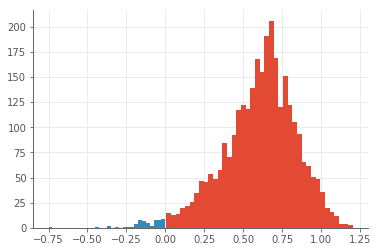

In [15]:
# look at diff between error radius and true error
index = 23
pt = world_points[index]
centers = np.array(calculated_centers[index])
radii = np.array(predicted_error_radius[index])
diffs = radii - np.linalg.norm(pt - centers, axis=1)
within = diffs[diffs > 0]
without = diffs[diffs < 0]
_ = plt.hist(within, bins=40)
_ = plt.hist(without, bins=30)
print("Within: {0}/{1} ... {2}".format(within.shape[0], centers.shape[0], float(within.shape[0])/centers.shape[0]))
print("Outside: {0}/{1} ... {2}".format(without.shape[0], centers.shape[0], float(without.shape[0])/centers.shape[0]))

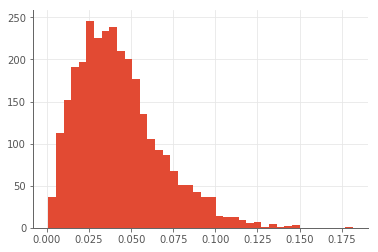

In [16]:

index = 3
pt = world_points[index]
diffs = np.linalg.norm(pt - calculated_centers[index], axis=1)
_ = plt.hist(diffs, bins=40)

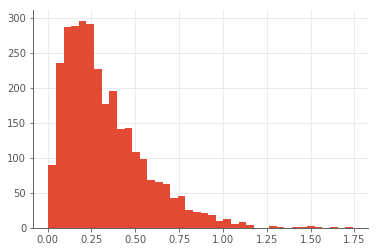

In [17]:

index = 22
pt = world_points[index]
diffs = np.linalg.norm(pt - calculated_centers[index], axis=1)
_ =plt.hist(diffs, bins=40)

In [ ]:
def get_error_elipse(r, minor_major_ratio, direction_vector):
    error_area = np.pi*r**2
    ratio = minor_axis/major_axis
    # use major/minor axis ratio to divvy up the area
    # area ellipse = pi*a*b, half major/minor axes
    # ratio = minor/major
    # => area = pi*a*a*ratio
    # => major_length = sqrt(area/(ratio*pi))
    major = np.sqrt(error_area/(ratio*np.pi))
    minor = error_area/(np.pi*major)
    # get angle to orient at next
    angle = np.arctan2(direction_vector[1], direction_vector[0])
    return (major, minor, angle)



# check if every point's error ellipse contains the true point
index = 24
pt = world_points[index]
calculated = np.array(calculated_centers[index][800:900])
fig = plt.figure(figsize=(3,3))
ax = plt.subplot(111)
print(pt)
print(len(world_points))
print (len(calculated_centers[index]))
ax.set_xlim(8,15)
ax.set_ylim(19,26)
n_within, n_total = 0, calculated.shape[0]
for i, center in enumerate(calculated):
    r = predicted_error_radius[index][i]
    maj_minors = np.array(major_minor_axes[index][i])
    major_axis, minor_axis = maj_minors 
    ratio = minor_axis/major_axis
    direction_vec = directions[index][i]
    major, minor, angle = get_error_elipse(r, ratio, direction_vec)
    el = Ellipse(center[:2], 2*major, 2*minor, angle=np.rad2deg(angle))
    if el.contains_point(pt[:2]):
        n_within += 1
        ax.scatter(*center[:2], color='green', s=3)
        el.set_edgecolor('blue')
        el.set_alpha(0.08)
    else:
        ax.scatter(*center[:2], color='blue', s=3)
        el.set_edgecolor('blue')
        el.set_alpha(1.0)
    el.set_fill(False)
    
    c = Ellipse(center[:2], 2*r, 2*r, angle=0.0)
    c.set_color('red')
#     if (np.linalg.norm(center[:2] - pt[:2]) <r ) != c.contains_point(pt[:2]):
#     print("{0}, center: {1}, distance: {2}, radius: {3}".format(pt[:2], center[:2], np.linalg.norm(pt - center),r))
    if c.contains_point(pt[:2]):
        c.set_alpha(0.08)
    else:
        c.set_linewidth(1.5)
        el.set_linewidth(1.5)
        c.set_alpha(1.0)
        el.set_alpha(1.0)
    
    ax.add_artist(el)
    c.set_fill(False)

    ax.add_artist(c)
ax.scatter(*pt[:2], color='red')

ax.set_xlabel("x")
ax.set_ylabel("y")
    
if save:
    plt.savefig("figs/ovals_vs_circles.pdf",bbox_inches='tight')
    plt.savefig("figs/ovals_vs_circles.pgf",bbox_inches='tight')
else:
    plt.show()

In [19]:
print("Within ellipse: {0}/{1} ... ".format(n_within, n_total, ))

Within ellipse: 98/100 ... 


In [20]:
def accuracy_of_ellipses(true_points, calculated_centers, calculated_radii, major_minors, dir_vecs):
    
    n_within, n_total = 0,0
    for i, true_point in enumerate(true_points):
        for j, center in enumerate(calculated_centers[i]):
            r = calculated_radii[i][j]
            major, minor = major_minors[i][j]
            direction = dir_vecs[i][j]
            major, minor, angle = get_error_elipse(r, minor/major, direction)
            
            ellipse = Ellipse(center[:2], 2*major, 2*minor, angle=np.rad2deg(angle))
            if ellipse.contains_point(true_point[:2]):
                n_within += 1
            
            n_total += 1
        
    return n_within, n_total

def accuracy_of_circles(true_points, calculated_centers, calculated_radii):
    n_within, n_total = 0,0
    for i, true_point in enumerate(true_points):
        for j, center in enumerate(calculated_centers[i]):
            if np.linalg.norm(center - true_point) < calculated_radii[i][j]:
                n_within += 1
            n_total += 1
    return n_within, n_total

In [21]:
within, total = accuracy_of_ellipses(world_points, calculated_centers,  predicted_error_radius, major_minor_axes, directions)
w, t = accuracy_of_circles(world_points, calculated_centers, predicted_error_radius)

In [22]:
print("Ellipse Accuracy: {0}/{1} ... {2}".format(within, total, float(within)/total))
print("Accuracy of Circle bounds: {0}/{1} ... {2}".format(w, t, float(w)/t))

Ellipse Accuracy: 74763/75000 ... 0.99684
Accuracy of Circle bounds: 74562/75000 ... 0.99416


In [23]:
# Examine Allows Positional/orientational errors at a fixed pitch angle!

In [26]:
pos_stddev_range = np.arange(0.00/2.0, 0.5/2.0, 0.05)
orient_stddev_range = np.arange(0.0, 2.0/2, 0.1)
camera_pos = np.array([0.0, 0.0, 6.0])
camera_pitch = 70.0
camera_yaw = 0.0
means_70 = np.zeros(shape=(pos_stddev_range.shape[0], orient_stddev_range.shape[0]))
medians_70, percentiles_70 = means_70.copy(), means_70.copy()
for j, pos_stddev in enumerate(pos_stddev_range):
    for i, orient_stddev in enumerate(orient_stddev_range):
        
        results = do_eval(camera_pos, camera_pitch, camera_yaw,
                          sigma_pos=pos_stddev, sigma_orient_deg=orient_stddev,
                          alg_error=4.0, camera_res=(2000,2000),
                          n_samples_per_camera=20, n_camera_instances=50)
        
        radii = results['predicted_error_radius']
        mean_70, median_70, percentile_70 = np.mean(radii), np.median(radii), np.percentile(radii, 95.0)
#         print(mean, median, percentile)
        
        means_70[j,i], medians_70[j,i], percentiles_70[j,i] = mean_70, median_70, percentile_70
        

In [27]:
# print("Orient Error:")
# print(orient_stddev_range.tolist())
# for i,m in enumerate(medians):
#     print("{1}".format(pos_stddev_range[i],m.tolist()))
print(2*orient_stddev_range)
print(2*pos_stddev_range)
print()
print(medians_70)

[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8]
[ 0.   0.1  0.2  0.3  0.4]
()
[[ 0.01759712  0.03427843  0.05170608  0.06873026  0.08649851  0.10383423
   0.12129725  0.13760983  0.15589424  0.17472434]
 [ 0.17784909  0.19609849  0.21488917  0.22907991  0.24670911  0.26620881
   0.28200353  0.30319289  0.31616312  0.33320349]
 [ 0.33940128  0.36032771  0.371698    0.3900931   0.41177493  0.42327743
   0.44824127  0.46118955  0.48338262  0.49953015]
 [ 0.50114386  0.51849615  0.53768887  0.55617838  0.57514578  0.5892666
   0.60768371  0.62536427  0.63933805  0.65908672]
 [ 0.66268097  0.68832513  0.69980975  0.71403281  0.73221986  0.7577493
   0.77018881  0.79077155  0.79622918  0.82933348]]


In [29]:
pos_stddev_range = np.arange(0.00/2.0, 0.5/2.0, 0.05)
orient_stddev_range = np.arange(0.0, 2.0/2, 0.1)
camera_pos = np.array([0.0, 0.0, 6.0])
camera_pitch = 45.0
camera_yaw = 0.0
means = np.zeros(shape=(pos_stddev_range.shape[0], orient_stddev_range.shape[0]))
medians, percentiles = means.copy(), means.copy()
for j, pos_stddev in enumerate(pos_stddev_range):
    for i, orient_stddev in enumerate(orient_stddev_range):
        
        results = do_eval(camera_pos, camera_pitch, camera_yaw,
                          sigma_pos=pos_stddev, sigma_orient_deg=orient_stddev,
                          alg_error=4.0, camera_res=(2000,2000),
                          n_samples_per_camera=20, n_camera_instances=50)
        
        radii = results['predicted_error_radius']
        mean, median, percentile = np.mean(radii), np.median(radii), np.percentile(radii, 95.0)
        
        means[j,i], medians[j,i], percentiles[j,i] = mean, median, percentile
        
       

KeyboardInterrupt: 

In [ ]:
print(2*orient_stddev_range)
print(2*pos_stddev_range)

print(medians)

In [ ]:
pos_stddev_range = np.arange(0.00/2.0, 0.5/2.0, 0.05)
orient_stddev_range = np.arange(0.0, 2.0/2, 0.1)
camera_pos = np.array([0.0, 0.0, 6.0])
camera_pitch = 90.0
camera_yaw = 0.0
means = np.zeros(shape=(pos_stddev_range.shape[0], orient_stddev_range.shape[0]))
medians, percentiles = means.copy(), means.copy()
for j, pos_stddev in enumerate(pos_stddev_range):
    for i, orient_stddev in enumerate(orient_stddev_range):
        
        results = do_eval(camera_pos, camera_pitch, camera_yaw,
                          sigma_pos=pos_stddev, sigma_orient_deg=orient_stddev,
                          alg_error=4.0, camera_res=(2000,2000),
                          n_samples_per_camera=20, n_camera_instances=50)
        
        radii = results['predicted_error_radius']
        mean, median, percentile = np.mean(radii), np.median(radii), np.percentile(radii, 95.0)
        
        means[j,i], medians[j,i], percentiles[j,i] = mean, median, percentile
        
       

In [ ]:
print(2*orient_stddev_range)
print(2*pos_stddev_range)

print(medians)